<a href="https://colab.research.google.com/github/AtharvaKodgule/DataScience/blob/main/LoanEligibilityPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Author: Data Science Assistant
# Goal: Predict Loan Approval (Yes/No) with comprehensive analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
class LoanApprovalPredictor:
    def __init__(self):
        self.models = {}
        self.best_model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_names = []

    def load_data(self, file_path=None):
        """Load and return sample loan dataset"""
        if file_path:
            self.df = pd.read_csv(file_path)
        else:
            # Create sample dataset for demonstration
            np.random.seed(42)
            n_samples = 1000

            # Generate synthetic loan data
            data = {
                'Gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.6, 0.4]),
                'Married': np.random.choice(['Yes', 'No'], n_samples, p=[0.7, 0.3]),
                'Dependents': np.random.choice(['0', '1', '2', '3+'], n_samples, p=[0.4, 0.3, 0.2, 0.1]),
                'Education': np.random.choice(['Graduate', 'Not Graduate'], n_samples, p=[0.8, 0.2]),
                'Self_Employed': np.random.choice(['Yes', 'No'], n_samples, p=[0.15, 0.85]),
                'ApplicantIncome': np.random.lognormal(10, 0.8, n_samples).astype(int),
                'CoapplicantIncome': np.random.lognormal(8, 1.2, n_samples).astype(int),
                'LoanAmount': np.random.lognormal(5, 0.5, n_samples).astype(int),
                'Loan_Amount_Term': np.random.choice([120, 180, 240, 300, 360], n_samples, p=[0.1, 0.15, 0.2, 0.25, 0.3]),
                'Credit_History': np.random.choice([0, 1], n_samples, p=[0.15, 0.85]),
                'Property_Area': np.random.choice(['Urban', 'Semiurban', 'Rural'], n_samples, p=[0.4, 0.35, 0.25])
            }

            # Create target variable with some logic
            loan_approval = []
            for i in range(n_samples):
                score = 0
                score += 20 if data['Credit_History'][i] == 1 else -30
                score += 15 if data['Education'][i] == 'Graduate' else -10
                score += 10 if data['Married'][i] == 'Yes' else -5
                score += min(data['ApplicantIncome'][i] / 1000, 30)
                score += min(data['CoapplicantIncome'][i] / 1000, 20)
                score -= data['LoanAmount'][i] / 100
                score += 5 if data['Property_Area'][i] == 'Urban' else 0

                # Add some randomness
                score += np.random.normal(0, 10)

                loan_approval.append('Y' if score > 30 else 'N')

            data['Loan_Status'] = loan_approval
            self.df = pd.DataFrame(data)

            # Introduce some missing values for realistic scenario
            missing_indices = np.random.choice(n_samples, size=int(0.1 * n_samples), replace=False)
            for idx in missing_indices[:len(missing_indices)//3]:
                self.df.loc[idx, 'LoanAmount'] = np.nan
            for idx in missing_indices[len(missing_indices)//3:2*len(missing_indices)//3]:
                self.df.loc[idx, 'Loan_Amount_Term'] = np.nan
            for idx in missing_indices[2*len(missing_indices)//3:]:
                self.df.loc[idx, 'Credit_History'] = np.nan

        print("Dataset loaded successfully!")
        print(f"Shape: {self.df.shape}")
        return self.df

    def explore_data(self):
        """Comprehensive data exploration"""
        print("="*50)
        print("DATA EXPLORATION")
        print("="*50)

        # Basic info
        print("\n1. Dataset Info:")
        print(self.df.info())

        print("\n2. First 5 rows:")
        print(self.df.head())

        print("\n3. Statistical Summary:")
        print(self.df.describe())

        # Missing values
        print("\n4. Missing Values:")
        missing = self.df.isnull().sum()
        missing_percent = (missing / len(self.df)) * 100
        missing_df = pd.DataFrame({
            'Missing Count': missing,
            'Percentage': missing_percent
        }).sort_values('Missing Count', ascending=False)
        print(missing_df[missing_df['Missing Count'] > 0])

        # Target variable distribution
        print("\n5. Target Variable Distribution:")
        print(self.df['Loan_Status'].value_counts())
        print(f"Approval Rate: {(self.df['Loan_Status'] == 'Y').mean():.2%}")

        # Categorical variables
        print("\n6. Categorical Variables:")
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if col != 'Loan_Status':
                print(f"\n{col}:")
                print(self.df[col].value_counts())

    def visualize_data(self):
        """Create comprehensive visualizations"""
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        fig.suptitle('Loan Approval Data Analysis', fontsize=16, fontweight='bold')

        # Target distribution
        self.df['Loan_Status'].value_counts().plot(kind='bar', ax=axes[0,0], color=['red', 'green'])
        axes[0,0].set_title('Loan Status Distribution')
        axes[0,0].set_xlabel('Loan Status')
        axes[0,0].set_ylabel('Count')

        # Income distribution
        axes[0,1].hist(self.df['ApplicantIncome'], bins=30, alpha=0.7, color='blue')
        axes[0,1].set_title('Applicant Income Distribution')
        axes[0,1].set_xlabel('Income')
        axes[0,1].set_ylabel('Frequency')

        # Loan amount vs approval
        approved = self.df[self.df['Loan_Status'] == 'Y']['LoanAmount'].dropna()
        rejected = self.df[self.df['Loan_Status'] == 'N']['LoanAmount'].dropna()
        axes[0,2].hist([approved, rejected], bins=20, alpha=0.7, label=['Approved', 'Rejected'], color=['green', 'red'])
        axes[0,2].set_title('Loan Amount by Approval Status')
        axes[0,2].legend()

        # Gender vs approval
        gender_approval = pd.crosstab(self.df['Gender'], self.df['Loan_Status'], normalize='index')
        gender_approval.plot(kind='bar', ax=axes[1,0], color=['red', 'green'])
        axes[1,0].set_title('Approval Rate by Gender')
        axes[1,0].set_ylabel('Approval Rate')

        # Education vs approval
        edu_approval = pd.crosstab(self.df['Education'], self.df['Loan_Status'], normalize='index')
        edu_approval.plot(kind='bar', ax=axes[1,1], color=['red', 'green'])
        axes[1,1].set_title('Approval Rate by Education')
        axes[1,1].set_ylabel('Approval Rate')

        # Credit history vs approval
        credit_approval = pd.crosstab(self.df['Credit_History'], self.df['Loan_Status'], normalize='index')
        credit_approval.plot(kind='bar', ax=axes[1,2], color=['red', 'green'])
        axes[1,2].set_title('Approval Rate by Credit History')
        axes[1,2].set_ylabel('Approval Rate')

        # Property area vs approval
        prop_approval = pd.crosstab(self.df['Property_Area'], self.df['Loan_Status'], normalize='index')
        prop_approval.plot(kind='bar', ax=axes[2,0], color=['red', 'green'])
        axes[2,0].set_title('Approval Rate by Property Area')
        axes[2,0].set_ylabel('Approval Rate')

        # Correlation heatmap of numerical features
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns
        corr_matrix = self.df[numerical_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2,1])
        axes[2,1].set_title('Correlation Matrix')

        # Missing values visualization
        missing_data = self.df.isnull().sum()
        missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
        if len(missing_data) > 0:
            missing_data.plot(kind='bar', ax=axes[2,2], color='orange')
            axes[2,2].set_title('Missing Values by Column')
            axes[2,2].set_ylabel('Missing Count')
        else:
            axes[2,2].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=12)
            axes[2,2].set_title('Missing Values')

        plt.tight_layout()
        plt.show()

    def feature_engineering(self):
        """Create new features based on domain knowledge"""
        print("\n" + "="*50)
        print("FEATURE ENGINEERING")
        print("="*50)

        # Create a copy for feature engineering
        self.df_processed = self.df.copy()

        # 1. Total Income
        self.df_processed['TotalIncome'] = (self.df_processed['ApplicantIncome'] +
                                             self.df_processed['CoapplicantIncome'])

        # 2. Loan to Income Ratio
        self.df_processed['LoanIncomeRatio'] = (self.df_processed['LoanAmount'] /
                                                 self.df_processed['TotalIncome'])

        # 3. Debt to Income Ratio (assuming loan amount as debt)
        self.df_processed['DebtIncomeRatio'] = (self.df_processed['LoanAmount'] /
                                                 self.df_processed['ApplicantIncome'])

        # 4. Income per dependent
        dependents_map = {'0': 0, '1': 1, '2': 2, '3+': 3}
        self.df_processed['Dependents_num'] = self.df_processed['Dependents'].map(dependents_map)
        self.df_processed['IncomePerDependent'] = (self.df_processed['TotalIncome'] /
                                                   (self.df_processed['Dependents_num'] + 1))

        # 5. Loan amount per term
        self.df_processed['LoanAmountPerTerm'] = (self.df_processed['LoanAmount'] /
                                                  self.df_processed['Loan_Amount_Term'])

        print("New features created:")
        new_features = ['TotalIncome', 'LoanIncomeRatio', 'DebtIncomeRatio',
                        'IncomePerDependent', 'LoanAmountPerTerm']
        for feature in new_features:
            print(f"- {feature}")

        return self.df_processed

    def preprocess_data(self):
        """Handle missing values and encode categorical variables"""
        print("\n" + "="*50)
        print("DATA PREPROCESSING")
        print("="*50)

        # Handle missing values
        print("1. Handling missing values...")

        # For numerical columns - use median
        numerical_cols = self.df_processed.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if self.df_processed[col].isnull().sum() > 0:
                median_val = self.df_processed[col].median()
                self.df_processed[col].fillna(median_val, inplace=True)
                print(f"    - {col}: filled with median ({median_val:.2f})")

        # For categorical columns - use mode
        categorical_cols = self.df_processed.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if col != 'Loan_Status' and self.df_processed[col].isnull().sum() > 0:
                mode_val = self.df_processed[col].mode()[0]
                self.df_processed[col].fillna(mode_val, inplace=True)
                print(f"    - {col}: filled with mode ({mode_val})")

        # Encode categorical variables
        print("\n2. Encoding categorical variables...")

        # Prepare features and target
        X = self.df_processed.drop('Loan_Status', axis=1)
        y = self.df_processed['Loan_Status']

        # Label encode target variable
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)  # 0 for 'N', 1 for 'Y'

        # Identify categorical and numerical columns
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

        print(f"    - Categorical features: {categorical_features}")
        print(f"    - Numerical features: {numerical_features}")

        # Create preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
            ])

        # Fit and transform the data
        X_processed = preprocessor.fit_transform(X)

        # Get feature names after preprocessing
        num_feature_names = numerical_features
        cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
        self.feature_names = num_feature_names + list(cat_feature_names)

        print(f"    - Final feature count: {X_processed.shape[1]}")

        self.X = X_processed
        self.y = y_encoded
        self.preprocessor = preprocessor
        self.le_target = le_target

        return X_processed, y_encoded

    def split_data(self, test_size=0.2, random_state=42):
        """Split data into train and test sets"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )

        print(f"\n3. Data split completed:")
        print(f"    - Training set: {self.X_train.shape[0]} samples")
        print(f"    - Test set: {self.X_test.shape[0]} samples")
        print(f"    - Training approval rate: {self.y_train.mean():.2%}")
        print(f"    - Test approval rate: {self.y_test.mean():.2%}")

    def handle_imbalanced_data(self):
        """Apply SMOTE to handle imbalanced data"""
        print("\n4. Handling imbalanced data with SMOTE...")

        # Check current class distribution
        unique, counts = np.unique(self.y_train, return_counts=True)
        print(f"    - Before SMOTE: {dict(zip(unique, counts))}")

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        self.X_train_balanced, self.y_train_balanced = smote.fit_resample(self.X_train, self.y_train)

        # Check new class distribution
        unique, counts = np.unique(self.y_train_balanced, return_counts=True)
        print(f"    - After SMOTE: {dict(zip(unique, counts))}")

        return self.X_train_balanced, self.y_train_balanced

    def train_models(self, use_balanced_data=True):
        """Train multiple models"""
        print("\n" + "="*50)
        print("MODEL TRAINING")
        print("="*50)

        # Choose training data
        if use_balanced_data and hasattr(self, 'X_train_balanced'):
            X_train_use = self.X_train_balanced
            y_train_use = self.y_train_balanced
            print("Using balanced training data (with SMOTE)")
        else:
            X_train_use = self.X_train
            y_train_use = self.y_train
            print("Using original training data")

        # Define models
        models = {
            'Logistic Regression': LogisticRegression(random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
            'SVM': SVC(random_state=42, probability=True)
        }

        # Train models
        print("\nTraining models...")
        for name, model in models.items():
            print(f"    - Training {name}...")
            model.fit(X_train_use, y_train_use)
            self.models[name] = model

        print("Model training completed!")

    def evaluate_models(self):
        """Comprehensive model evaluation"""
        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)

        results = []

        for name, model in self.models.items():
            # Predictions
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]

            # Metrics
            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred)

            # Cross-validation score
            cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5)
            cv_mean = cv_scores.mean()

            results.append({
                'Model': name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'CV Score': cv_mean
            })

            print(f"\n{name} Results:")
            print(f"    Accuracy: {accuracy:.4f}")
            print(f"    Precision: {precision:.4f}")
            print(f"    Recall: {recall:.4f}")
            print(f"    F1-Score: {f1:.4f}")
            print(f"    CV Score: {cv_mean:.4f} (+/- {cv_scores.std() * 2:.4f})")

        # Create results DataFrame
        self.results_df = pd.DataFrame(results)
        print("\n" + "="*50)
        print("MODEL COMPARISON SUMMARY")
        print("="*50)
        print(self.results_df.round(4))

        # Find best model
        best_model_name = self.results_df.loc[self.results_df['Accuracy'].idxmax(), 'Model']
        self.best_model = self.models[best_model_name]
        print(f"\nBest Model: {best_model_name}")

        return self.results_df

    def plot_model_comparison(self):
        """Plot model comparison"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

        for i, metric in enumerate(metrics):
            ax = axes[i//2, i%2]
            bars = ax.bar(self.results_df['Model'], self.results_df[metric],
                          color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
            ax.set_title(f'{metric} Comparison')
            ax.set_ylabel(metric)
            ax.set_ylim(0, 1)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom')

            # Rotate x-axis labels
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

        for i, (name, model) in enumerate(self.models.items()):
            ax = axes[i//2, i%2]
            y_pred = model.predict(self.X_test)
            cm = confusion_matrix(self.y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                        xticklabels=['Rejected', 'Approved'],
                        yticklabels=['Rejected', 'Approved'])
            ax.set_title(f'{name}')
            ax.set_ylabel('True Label')
            ax.set_xlabel('Predicted Label')

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self):
        """Plot ROC curves for all models"""
        plt.figure(figsize=(10, 8))

        for name, model in self.models.items():
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, linewidth=2,
                     label=f'{name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def hyperparameter_tuning(self, model_name='Random Forest'):
        """Perform hyperparameter tuning for the specified model"""
        print(f"\n" + "="*50)
        print(f"HYPERPARAMETER TUNING - {model_name.upper()}")
        print("="*50)

        if model_name == 'Random Forest':
            model = RandomForestClassifier(random_state=42)
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [5, 10, 15, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        elif model_name == 'Logistic Regression':
            model = LogisticRegression(random_state=42)
            param_grid = {
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']
            }
        elif model_name == 'SVM':
            model = SVC(random_state=42, probability=True)
            param_grid = {
                'C': [0.1, 1, 10, 100],
                'kernel': ['rbf', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto', 0.001, 0.01]
            }
        else:
            print(f"Hyperparameter tuning not implemented for {model_name}")
            return None

        # Use balanced data if available
        X_train_use = self.X_train_balanced if hasattr(self, 'X_train_balanced') else self.X_train
        y_train_use = self.y_train_balanced if hasattr(self, 'y_train_balanced') else self.y_train

        # Grid search with stratified k-fold
        print("Performing grid search...")
        grid_search = GridSearchCV(
            model, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='accuracy', n_jobs=-1, verbose=1
        )

        grid_search.fit(X_train_use, y_train_use)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        # Update the model with best parameters
        self.models[f'{model_name} (Tuned)'] = grid_search.best_estimator_

        # Evaluate tuned model
        y_pred_tuned = grid_search.best_estimator_.predict(self.X_test)
        accuracy_tuned = accuracy_score(self.y_test, y_pred_tuned)
        print(f"Test accuracy with tuned model: {accuracy_tuned:.4f}")

        return grid_search.best_estimator_

    def feature_importance_analysis(self):
        """Analyze feature importance"""
        print("\n" + "="*50)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*50)

        # Get feature importance from Random Forest (if available)
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']
            feature_importance = rf_model.feature_importances_

            # Create feature importance DataFrame
            importance_df = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': feature_importance
            }).sort_values('Importance', ascending=False)

            print("Top 10 Most Important Features:")
            print(importance_df.head(10).round(4))

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            top_features = importance_df.head(15)
            plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 15 Feature Importance (Random Forest)')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

            return importance_df
        else:
            print("Random Forest model not available for feature importance analysis")
            return None

    def create_prediction_function(self):
        """Create a function for making predictions on new data"""
        def predict_loan_approval(gender, married, dependents, education, self_employed,
                                 applicant_income, coapplicant_income, loan_amount,
                                 loan_amount_term, credit_history, property_area):
            """
            Predict loan approval for new applicant

            Parameters:
            - gender: 'Male' or 'Female'
            - married: 'Yes' or 'No'
            - dependents: '0', '1', '2', or '3+'
            - education: 'Graduate' or 'Not Graduate'
            - self_employed: 'Yes' or 'No'
            - applicant_income: int (monthly income)
            - coapplicant_income: int (co-applicant monthly income)
            - loan_amount: int (in thousands)
            - loan_amount_term: int (in months, e.g., 360)
            - credit_history: 1 (good) or 0 (bad)
            - property_area: 'Urban', 'Semiurban', or 'Rural'

            Returns:
            - prediction: 'Approved' or 'Rejected'
            - probability: probability of approval
            """

            # Create input dataframe
            input_data = pd.DataFrame({
                'Gender': [gender],
                'Married': [married],
                'Dependents': [dependents],
                'Education': [education],
                'Self_Employed': [self_employed],
                'ApplicantIncome': [applicant_income],
                'CoapplicantIncome': [coapplicant_income],
                'LoanAmount': [loan_amount],
                'Loan_Amount_Term': [loan_amount_term],
                'Credit_History': [credit_history],
                'Property_Area': [property_area]
            })

            # Feature engineering
            input_data['TotalIncome'] = input_data['ApplicantIncome'] + input_data['CoapplicantIncome']
            input_data['LoanIncomeRatio'] = input_data['LoanAmount'] / input_data['TotalIncome']
            input_data['DebtIncomeRatio'] = input_data['LoanAmount'] / input_data['ApplicantIncome']

            dependents_map = {'0': 0, '1': 1, '2': 2, '3+': 3}
            input_data['Dependents_num'] = input_data['Dependents'].map(dependents_map)
            input_data['IncomePerDependent'] = input_data['TotalIncome'] / (input_data['Dependents_num'] + 1)
            input_data['LoanAmountPerTerm'] = input_data['LoanAmount'] / input_data['Loan_Amount_Term']

            # Preprocess the input
            input_processed = self.preprocessor.transform(input_data)

            # Make prediction
            prediction = self.best_model.predict(input_processed)[0]
            probability = self.best_model.predict_proba(input_processed)[0, 1]

            result = 'Approved' if prediction == 1 else 'Rejected'

            return result, probability

        return predict_loan_approval

    def generate_business_insights(self):
        """Generate business insights from the analysis"""
        print("\n" + "="*50)
        print("BUSINESS INSIGHTS & RECOMMENDATIONS")
        print("="*50)

        insights = []

        # 1. Approval rate insights
        approval_rate = (self.df['Loan_Status'] == 'Y').mean()
        insights.append(f"Overall loan approval rate: {approval_rate:.2%}")

        # 2. Credit history impact
        credit_impact = self.df.groupby('Credit_History')['Loan_Status'].apply(lambda x: (x == 'Y').mean())
        if 1.0 in credit_impact.index and 0.0 in credit_impact.index:
            insights.append(f"Credit history impact: {credit_impact[1.0]:.2%} vs {credit_impact[0.0]:.2%} approval rate")

        # 3. Education impact
        edu_impact = self.df.groupby('Education')['Loan_Status'].apply(lambda x: (x == 'Y').mean())
        insights.append("Education impact: " + ", ".join([f"{edu}: {rate:.2%}" for edu, rate in edu_impact.items()]))

        # 4. Property area impact
        prop_impact = self.df.groupby('Property_Area')['Loan_Status'].apply(lambda x: (x == 'Y').mean())
        insights.append("Property area impact: " + ", ".join([f"{area}: {rate:.2%}" for area, rate in prop_impact.items()]))

        # 5. Income analysis
        approved_income = self.df[self.df['Loan_Status'] == 'Y']['ApplicantIncome'].median()
        rejected_income = self.df[self.df['Loan_Status'] == 'N']['ApplicantIncome'].median()
        insights.append(f"Median income - Approved: ₹{approved_income:,.0f}, Rejected: ₹{rejected_income:,.0f}")

        for i, insight in enumerate(insights, 1):
            print(f"{i}. {insight}")

        print("\nRecommendations:")
        recommendations = [
            "Focus on applicants with good credit history for higher approval rates",
            "Consider income-to-loan ratio as a key factor in decision making",
            "Implement risk-based pricing for different customer segments",
            "Develop targeted marketing for high-approval segments",
            "Create financial literacy programs for rejected applicants"
        ]

        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")

    def run_complete_analysis(self, file_path=None):
        """Run the complete loan approval prediction analysis"""
        print("🚀 LOAN APPROVAL PREDICTION - COMPLETE ANALYSIS")
        print("=" * 60)

        # 1. Load and explore data
        self.load_data(file_path)
        self.explore_data()
        self.visualize_data()

        # 2. Feature engineering and preprocessing
        self.feature_engineering()
        self.preprocess_data()
        self.split_data()
        self.handle_imbalanced_data()

        # 3. Model training and evaluation
        self.train_models(use_balanced_data=True)
        self.evaluate_models()

        # 4. Visualizations
        self.plot_model_comparison()
        self.plot_confusion_matrices()
        self.plot_roc_curves()

        # 5. Advanced analysis
        self.hyperparameter_tuning('Random Forest')
        self.feature_importance_analysis()

        # 6. Business insights
        self.generate_business_insights()

        # 7. Create prediction function
        predict_func = self.create_prediction_function()

        print("\n" + "="*60)
        print("✅ ANALYSIS COMPLETED!")
        print("="*60)
        print("\nYou can now use the trained models to make predictions on new data.")
        print("Use the returned prediction function to make individual predictions.")

        return predict_func

In [ ]:
# USAGE EXAMPLE AND DEMO
def demo_loan_prediction():
    """Demonstrate the loan prediction system"""
    print("🎯 LOAN APPROVAL PREDICTION DEMO")
    print("="*50)

    # Initialize and run analysis
    predictor = LoanApprovalPredictor()
    predict_function = predictor.run_complete_analysis()

    # Demo predictions
    print("\n🔮 SAMPLE PREDICTIONS:")
    print("-" * 30)

    # Test case 1: High probability approval
    result1, prob1 = predict_function(
        gender='Male', married='Yes', dependents='1', education='Graduate',
        self_employed='No', applicant_income=5000, coapplicant_income=2000,
        loan_amount=150, loan_amount_term=360, credit_history=1, property_area='Urban'
    )
    print(f"Test Case 1 - High Income, Good Credit:")
    print(f"Prediction: {result1} (Probability: {prob1:.2%})")

    # Test case 2: Low probability approval
    result2, prob2 = predict_function(
        gender='Female', married='No', dependents='0', education='Not Graduate',
        self_employed='Yes', applicant_income=2000, coapplicant_income=0,
        loan_amount=200, loan_amount_term=240, credit_history=0, property_area='Rural'
    )
    print(f"\nTest Case 2 - Low Income, Bad Credit:")
    print(f"Prediction: {result2} (Probability: {prob2:.2%})")

    # Test case 3: Moderate case
    result3, prob3 = predict_function(
        gender='Male', married='Yes', dependents='2', education='Graduate',
        self_employed='No', applicant_income=4000, coapplicant_income=1500,
        loan_amount=180, loan_amount_term=360, credit_history=1, property_area='Semiurban'
    )
    print(f"\nTest Case 3 - Moderate Profile:")
    print(f"Prediction: {result3} (Probability: {prob3:.2%})")

    return predictor, predict_function

In [ ]:
# USAGE EXAMPLE AND DEMO
def demo_loan_prediction():
    """Demonstrate the loan prediction system"""
    print("🎯 LOAN APPROVAL PREDICTION DEMO")
    print("="*50)

    # Initialize and run analysis
    predictor = LoanApprovalPredictor()
    predict_function = predictor.run_complete_analysis()

    # Demo predictions
    print("\n🔮 SAMPLE PREDICTIONS:")
    print("-" * 30)

    # Test case 1: High probability approval
    result1, prob1 = predict_function(
        gender='Male', married='Yes', dependents='1', education='Graduate',
        self_employed='No', applicant_income=5000, coapplicant_income=2000,
        loan_amount=150, loan_amount_term=360, credit_history=1, property_area='Urban'
    )
    print(f"Test Case 1 - High Income, Good Credit:")
    print(f"Prediction: {result1} (Probability: {prob1:.2%})")

    # Test case 2: Low probability approval
    result2, prob2 = predict_function(
        gender='Female', married='No', dependents='0', education='Not Graduate',
        self_employed='Yes', applicant_income=2000, coapplicant_income=0,
        loan_amount=200, loan_amount_term=240, credit_history=0, property_area='Rural'
    )
    print(f"\nTest Case 2 - Low Income, Bad Credit:")
    print(f"Prediction: {result2} (Probability: {prob2:.2%})")

    # Test case 3: Moderate case
    result3, prob3 = predict_function(
        gender='Male', married='Yes', dependents='2', education='Graduate',
        self_employed='No', applicant_income=4000, coapplicant_income=1500,
        loan_amount=180, loan_amount_term=360, credit_history=1, property_area='Semiurban'
    )
    print(f"\nTest Case 3 - Moderate Profile:")
    print(f"Prediction: {result3} (Probability: {prob3:.2%})")

    return predictor, predict_function

In [ ]:
# STREAMLIT WEB APP CODE (Bonus)
def create_streamlit_app():
    """
    Create a Streamlit web application for loan prediction

    To use this, save it as a separate file (e.g., loan_app.py) and run:
    streamlit run loan_app.py
    """
    streamlit_code = '''
import streamlit as st
import pandas as pd
import numpy as np
from loan_predictor import LoanApprovalPredictor  # Import your main class

st.set_page_config(page_title="Loan Approval Predictor", page_icon="🏦", layout="wide")

st.title("🏦 Loan Approval Prediction System")
st.markdown("Get instant loan approval predictions based on your profile!")

# Initialize session state
if 'model_trained' not in st.session_state:
    st.session_state.model_trained = False
    st.session_state.predictor = None

# Sidebar for model training
with st.sidebar:
    st.header("🔧 Model Setup")
    if st.button("Train Model", type="primary"):
        with st.spinner("Training models... This may take a few minutes."):
            predictor = LoanApprovalPredictor()
            predictor.load_data()
            predictor.feature_engineering()
            predictor.preprocess_data()
            predictor.split_data()
            predictor.handle_imbalanced_data()
            predictor.train_models()
            predictor.evaluate_models()

            st.session_state.predictor = predictor
            st.session_state.model_trained = True
        st.success("✅ Models trained successfully!")

# Main interface
if st.session_state.model_trained:
    col1, col2 = st.columns(2)

    with col1:
        st.header("📝 Applicant Information")
        gender = st.selectbox("Gender", ["Male", "Female"])
        married = st.selectbox("Marital Status", ["Yes", "No"])
        dependents = st.selectbox("Number of Dependents", ["0", "1", "2", "3+"])
        education = st.selectbox("Education", ["Graduate", "Not Graduate"])
        self_employed = st.selectbox("Self Employed", ["No", "Yes"])
        property_area = st.selectbox("Property Area", ["Urban", "Semiurban", "Rural"])

    with col2:
        st.header("💰 Financial Information")
        applicant_income = st.number_input("Applicant Income (₹/month)", min_value=0, value=5000, step=500)
        coapplicant_income = st.number_input("Co-applicant Income (₹/month)", min_value=0, value=0, step=500)
        loan_amount = st.number_input("Loan Amount (₹ thousands)", min_value=0, value=150, step=10)
        loan_term = st.selectbox("Loan Term (months)", [120, 180, 240, 300, 360])
        credit_history = st.selectbox("Credit History", [1, 0], format_func=lambda x: "Good" if x == 1 else "Bad")

    # Prediction
    if st.button("🔮 Predict Loan Approval", type="primary", use_container_width=True):
        try:
            predict_func = st.session_state.predictor.create_prediction_function()
            result, probability = predict_func(
                gender, married, dependents, education, self_employed,
                applicant_income, coapplicant_income, loan_amount,
                loan_term, credit_history, property_area
            )

            # Display result
            if result == "Approved":
                st.success(f"🎉 Loan {result}!")
                st.success(f"Approval Probability: {probability:.2%}")
            else:
                st.error(f"❌ Loan {result}")
                st.error(f"Approval Probability: {probability:.2%}")

            # Additional insights
            st.subheader("📊 Recommendation")
            if probability < 0.3:
                st.warning("Consider improving credit history or increasing income.")
            elif probability < 0.7:
                st.info("Moderate approval chance. Consider reducing loan amount.")
            else:
                st.success("Strong profile for loan approval!")

        except Exception as e:
            st.error(f"Error making prediction: {str(e)}")
else:
    st.warning("⚠️ Please train the model first using the sidebar.")
    st.info("The model training process will create and evaluate multiple machine learning models for loan approval prediction.")
'''

    print("\n" + "="*50)
    print("STREAMLIT WEB APP CODE")
    print("="*50)
    print("Save the following code as 'loan_app.py' and run 'streamlit run loan_app.py':")
    print(streamlit_code)

🎯 LOAN APPROVAL PREDICTION DEMO
🚀 LOAN APPROVAL PREDICTION - COMPLETE ANALYSIS
Dataset loaded successfully!
Shape: (1000, 12)
DATA EXPLORATION

1. Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             1000 non-null   object 
 1   Married            1000 non-null   object 
 2   Dependents         1000 non-null   object 
 3   Education          1000 non-null   object 
 4   Self_Employed      1000 non-null   object 
 5   ApplicantIncome    1000 non-null   int64  
 6   CoapplicantIncome  1000 non-null   int64  
 7   LoanAmount         967 non-null    float64
 8   Loan_Amount_Term   967 non-null    float64
 9   Credit_History     966 non-null    float64
 10  Property_Area      1000 non-null   object 
 11  Loan_Status        1000 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 93.9+ K

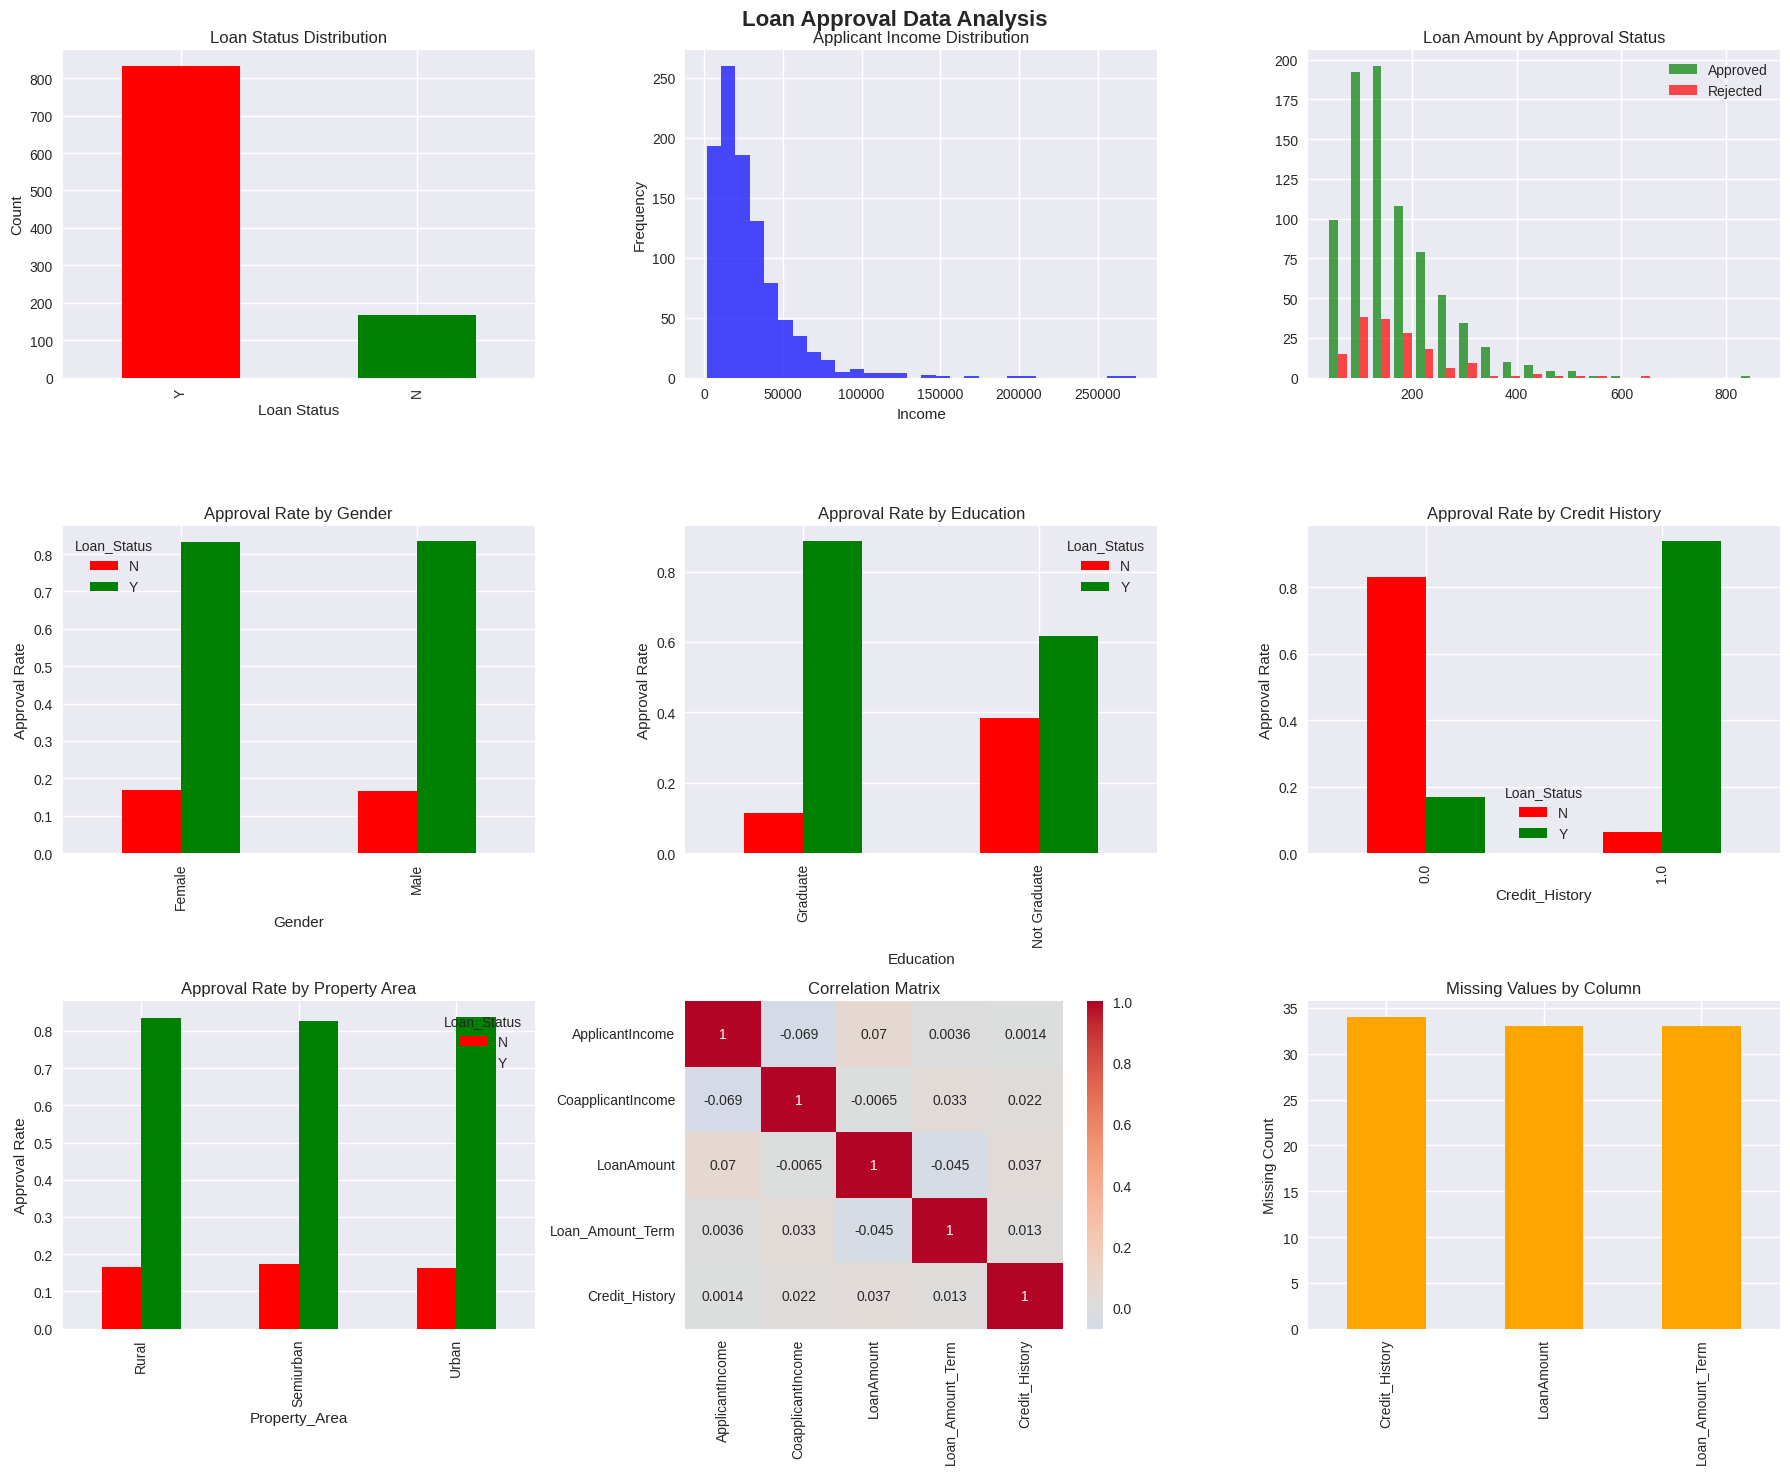


FEATURE ENGINEERING
New features created:
- TotalIncome
- LoanIncomeRatio
- DebtIncomeRatio
- IncomePerDependent
- LoanAmountPerTerm

DATA PREPROCESSING
1. Handling missing values...
    - LoanAmount: filled with median (145.00)
    - Loan_Amount_Term: filled with median (300.00)
    - Credit_History: filled with median (1.00)
    - LoanIncomeRatio: filled with median (0.01)
    - DebtIncomeRatio: filled with median (0.01)
    - LoanAmountPerTerm: filled with median (0.56)

2. Encoding categorical variables...
    - Categorical features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
    - Numerical features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanIncomeRatio', 'DebtIncomeRatio', 'Dependents_num', 'IncomePerDependent', 'LoanAmountPerTerm']
    - Final feature count: 20

3. Data split completed:
    - Training set: 800 samples
    - Test set: 200 samples
    - Training approval

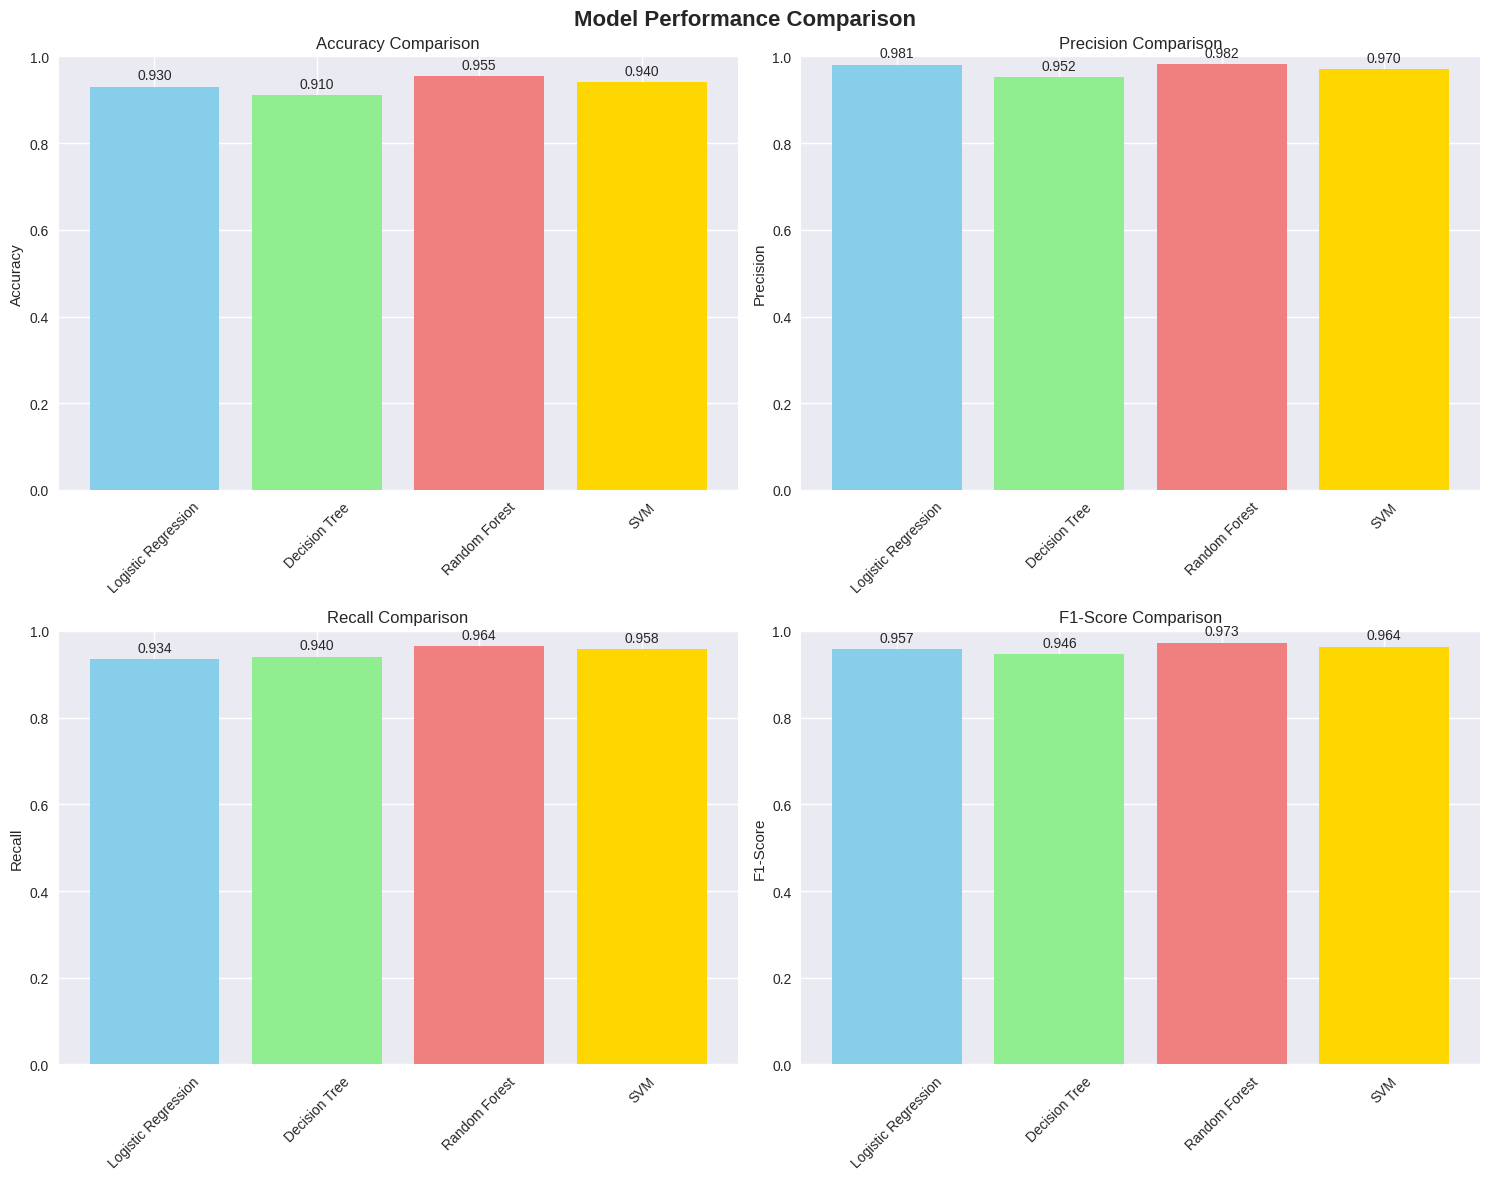

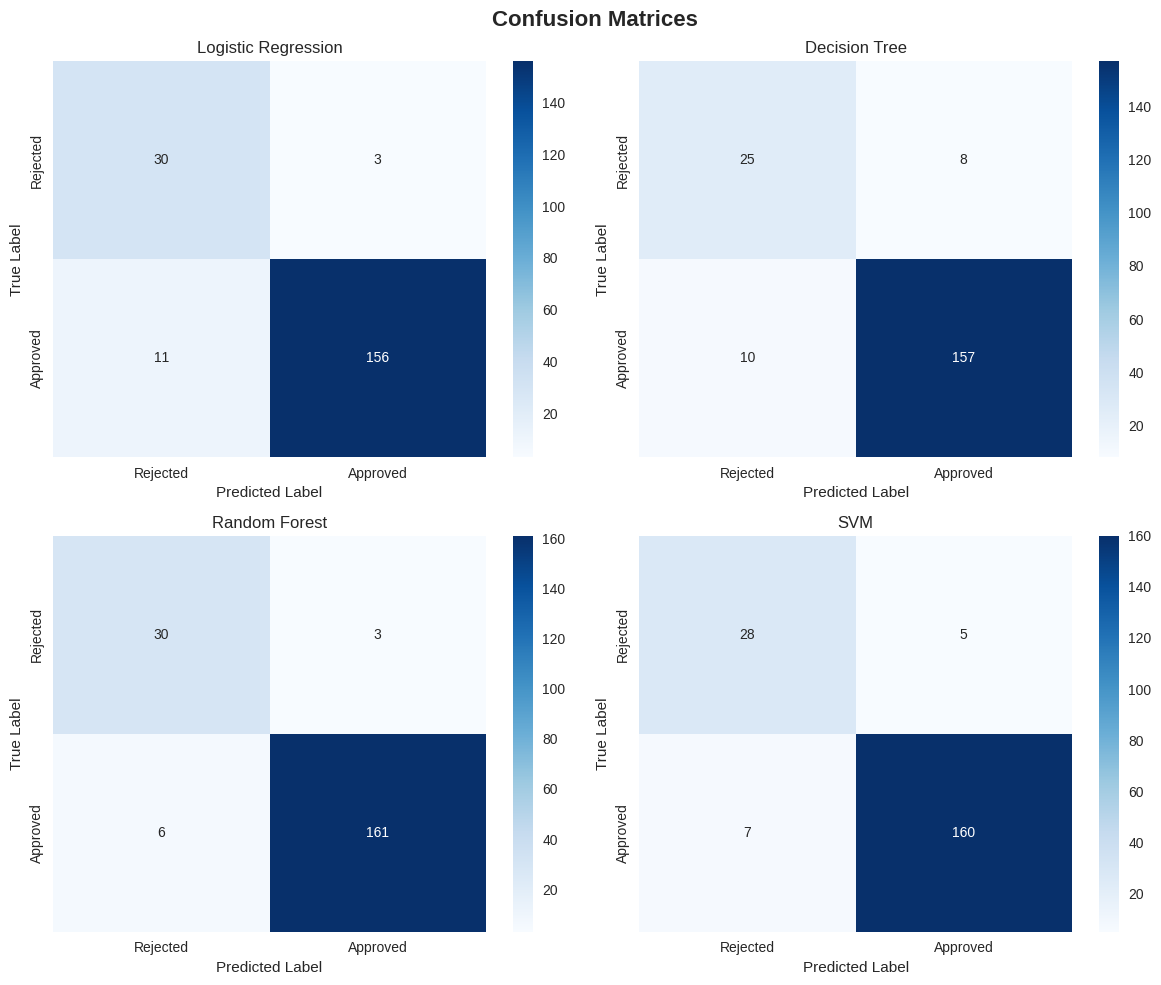

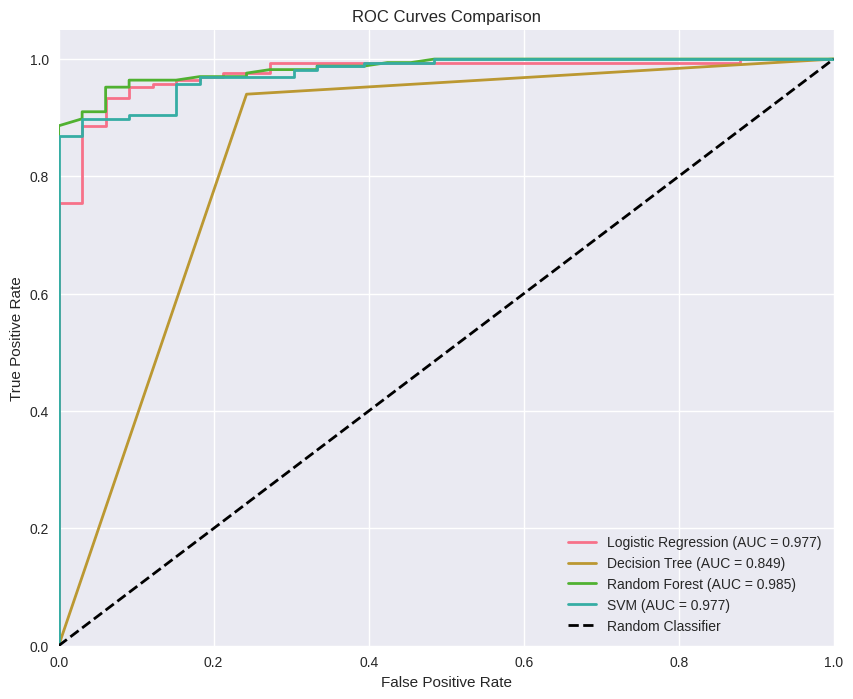


HYPERPARAMETER TUNING - RANDOM FOREST
Performing grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9752
Test accuracy with tuned model: 0.9500

FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
                   Feature  Importance
4           Credit_History      0.3809
16  Education_Not Graduate      0.1572
12             Married_Yes      0.0543
5              TotalIncome      0.0519
0          ApplicantIncome      0.0396
6          LoanIncomeRatio      0.0379
1        CoapplicantIncome      0.0345
2               LoanAmount      0.0328
7          DebtIncomeRatio      0.0316
10       LoanAmountPerTerm      0.0301


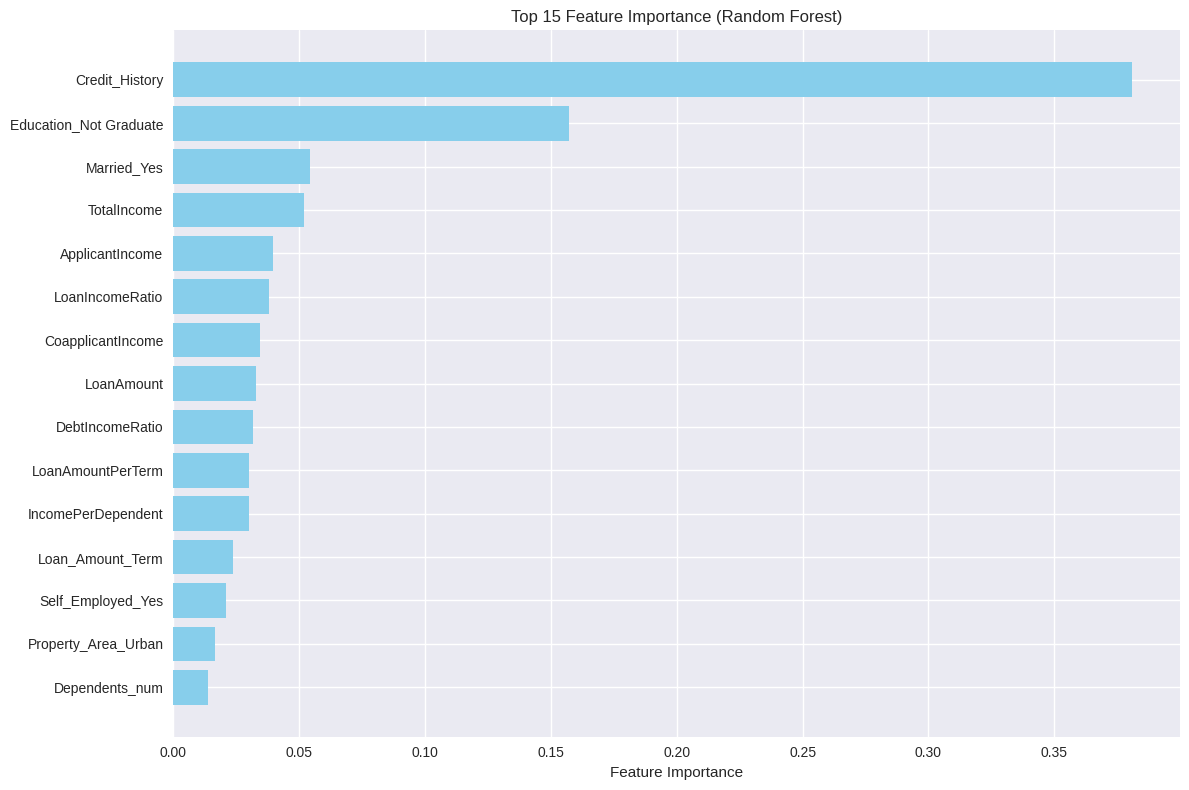


BUSINESS INSIGHTS & RECOMMENDATIONS
1. Overall loan approval rate: 83.30%
2. Credit history impact: 93.73% vs 16.91% approval rate
3. Education impact: Graduate: 88.56%, Not Graduate: 61.73%
4. Property area impact: Rural: 83.40%, Semiurban: 82.75%, Urban: 83.71%
5. Median income - Approved: ₹22,533, Rejected: ₹18,134

Recommendations:
1. Focus on applicants with good credit history for higher approval rates
2. Consider income-to-loan ratio as a key factor in decision making
3. Implement risk-based pricing for different customer segments
4. Develop targeted marketing for high-approval segments
5. Create financial literacy programs for rejected applicants

✅ ANALYSIS COMPLETED!

You can now use the trained models to make predictions on new data.
Use the returned prediction function to make individual predictions.

🔮 SAMPLE PREDICTIONS:
------------------------------
Test Case 1 - High Income, Good Credit:
Prediction: Approved (Probability: 91.00%)

Test Case 2 - Low Income, Bad Credit:

In [ ]:
# Run the complete demo
if __name__ == "__main__":
    # Run the complete analysis
    predictor, predict_func = demo_loan_prediction()

    # Show Streamlit app code
    create_streamlit_app()

    print("\n🎯 PROJECT COMPLETED SUCCESSFULLY!")
    print("="*50)
    print("Next Steps:")
    print("1. Deploy the model using Flask/FastAPI for REST API")
    print("2. Create a Streamlit web app for user interface")
    print("3. Set up model monitoring and retraining pipelines")
    print("4. Implement A/B testing for model improvements")
    print("5. Add explainability features using SHAP/LIME")
    print("6. Connect to database for storing predictions")
    print("7. Add fairness auditing for bias detection")